**disini data dinamis dimana setiap pola pada timestep , itu di normalisasi dan diskalalisasi , serta ditambah feature  vektor  titik t dengan t-1**
1. filter21 sudah di dropna, sudah di gabung dengan diff1 yaitu range titik t  HANYA BELUM DITRIM
2. filter23, fix siap dilatih sudah di TRIM , sudah di dropna, sudah di gabung dengan diff1 yaitu range titik t dengan t-1
3. diff1 , range titik t dengan t-1


RAW  -> NORMALISASI ->  DROPNA -> TRIM

# 📚 Daftar Isi

1. [📂 Renamed File](#RENAMED-FILE)
2. [📦 Import Library](#import-library)
3. [📊 Count Sample and Sequence Dataset](#count-sample-and-seq-csv)
4. [📈 Visualisasi Sample & Sequence](#visualisasi-sample-seq)
5. [🎞️ Extract Video](#extract-vidio)
6. [🔗 Combine / Concat CSV Vertikal](#combineD-I)
7. [📉 Difference (Perubahan Koordinat)](#difference)
8. [✂️ Trimmed Dataset](#trimmed)
9. [🧠 Selisih Koordinat Tangan dengan Kepala](#NORMALISASI-HEAD-KEPALA)
10. [🧮 Normalisasi Berdasarkan Resolusi Frame](#Normalisasi-Jika-NIlai-Koordinat-kepala-sebelumnya-dikali-Panjang-dan-lebar-Frame)
11. [📑 Pindahkan Kolom timestep, label, sequence ke Akhir](#MOVE-KOLOM-timestep,-Label-,Sequence-ke-3-terakhir)
12. [⚙️ TensorFlow (Tanpa cuDNN)](#tensorflow-without-cudnn)
13. [🎯 Seleksi Parameter](#seleksi-parameter)
14. [🧾 Convert to Array](#convert-to-array)

---

## 📂 Data Preparation

- [🔀 Split Data 1](#split-data-1)
- [🔀 Split Data 2](#split-data-2)
- [🏷️ Buat Label Map dengan PKL](#buat-label-map-dengan-pkl-dan-disimpan)

---

## 🧠 Model Development

- [⏹️ Early Stopping](#early-stopping)
- [📚 LSTM Fundamental Model I](#lstm-fundamental-model-i)
- [📚 LSTM Fundamental Model II](#lstm-fundamental-model-ii)
- [📚 LSTM Fundamental Model III](#lstm-fundamental-model-iii)
- [💾 Save Model](#save-model)

---

## 🎨 Visualisasi

- [🖼️ Visualisasi Perubahan Landmark](#visualisasi-perubahan-landmark)

## Collecting Result Research Data
- [Memecah frame frame pada vidio mkv jadi file file gambar jpg di dalam folder](#MEMECAH-FRAME-FRAME-VIDIO-JADI-FILE-JPG)


# 📁 Penjelasan Struktur Direktori Proyek

Dokumen ini menjelaskan tujuan dan isi dari masing-masing direktori dalam proyek ini. Tujuannya adalah agar setiap pengguna atau developer memahami fungsi masing-masing folder dengan jelas dan efisien.

---

## 📁 Tabel Penjelasan File di `csv/dinamic`

| **Nama File**             | **Penjelasan**                                                                                                 |
|---------------------------|-----------------------------------------------------------------------------------------------------------------|
| `raw_v1.csv`              | Data mentah hasil ekstraksi gesture dinamis (misalnya dari MediaPipe), belum dinormalisasi atau diberi label. |
| `preprocessed_v1.csv`     | Data yang telah melalui preprocessing: normalisasi, penyusunan sequence, pemberian label, dan filter noise.    |

📌 *Gunakan penamaan versi (`v1`, `v2`, dst.) untuk menandai perubahan preprocessing atau ekstraksi.*


## 🧠 Tabel Penjelasan Model di `models/`

| **Nama File Model** | **Preprocessing**                                                     | **Koordinat yang Terlibat**                                 |
|---------------------|------------------------------------------------------------------------|--------------------------------------------------------------|
| `dyn_1.h5`          | Selisih koordinat antara **tangan kanan** dan **kepala**              | `Xr*`, `Yr*`, `Zl0`, `Zl4`, `Zl8`, `Zl12`                    |

📌 Keterangan:
- `Xr*`, `Yr*` = Semua titik tangan kanan, hanya komponen **X** dan **Y**
- `Zl0`, `Zl4`, `Zl8`, `Zl12` = Komponen **Z** dari titik-titik tertentu di tangan kiri





## RENAMED FILE

In [12]:
import os

root_folder = "video"

# Telusuri semua subfolder dalam folder "video"
for subfolder in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder)
    
    if os.path.isdir(subfolder_path):
        # Ambil semua file .mp4 dan urutkan berdasarkan angka
        mp4_files = [f for f in os.listdir(subfolder_path) if f.endswith(".mp4")]
        mp4_files.sort(key=lambda x: int(x.replace(".mp4", "")))

        # Rename mulai dari 86
        for idx, filename in enumerate(mp4_files, start=86):
            old_path = os.path.join(subfolder_path, filename)
            new_filename = f"{idx}.mp4"
            new_path = os.path.join(subfolder_path, new_filename)
            os.rename(old_path, new_path)
            print(f"Renamed {old_path} -> {new_path}")


Renamed video/z/86.mp4 -> video/z/86.mp4
Renamed video/z/87.mp4 -> video/z/87.mp4
Renamed video/z/88.mp4 -> video/z/88.mp4
Renamed video/z/89.mp4 -> video/z/89.mp4
Renamed video/z/90.mp4 -> video/z/90.mp4
Renamed video/z/91.mp4 -> video/z/91.mp4
Renamed video/z/92.mp4 -> video/z/92.mp4
Renamed video/z/93.mp4 -> video/z/93.mp4
Renamed video/z/94.mp4 -> video/z/94.mp4
Renamed video/z/95.mp4 -> video/z/95.mp4
Renamed video/z/96.mp4 -> video/z/96.mp4
Renamed video/z/97.mp4 -> video/z/97.mp4
Renamed video/z/98.mp4 -> video/z/98.mp4


## IMPORT LIBRARY

In [13]:
import os
import pandas as pd
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import pandas as pd

2025-07-04 23:00:36.512363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-04 23:00:36.521848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751644836.531145   50753 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751644836.533943   50753 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751644836.543200   50753 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## COUNT SAMPLE AND SEQ CSV

In [ ]:
import pandas as pd

# 1. Baca dataset
df = pd.read_csv('csv/dinamic/preprocessed_v1.csv')

# 2. Jumlah sample (baris) per label
jumlah_sample_per_label = df['Label'].value_counts().sort_index()
print("Jumlah sample (frame) per label:\n", jumlah_sample_per_label)

# 3. Jumlah sequence unik per label
if 'sequence' in df.columns:
    jumlah_sequence_per_label = df.groupby('Label')['sequence'].nunique().sort_index()
    print("\nJumlah sequence per label:\n", jumlah_sequence_per_label)
else:
    print("\nKolom 'sequence' tidak ditemukan dalam dataset.")


Jumlah sample (frame) per label:
 Label
10        1760
cepat     1760
j         1760
kita      1760
lihat     1760
menang    1760
paham     1760
tidak     1760
z         1760
Name: count, dtype: int64

Kolom 'sequence' tidak ditemukan dalam dataset.


In [3]:
pd.read_csv('csv/dinamic/preprocessed_v1.csv')

,Xl0,Xl1,Xl2,Xl3,Xl4,Xl5,Xl6,Xl7,Xl8,Xl9,...,Yh1,Xh2,Yh2,Xh3,Yh3,Xh4,Yh4,timestep,sequence,Label
0,-0.320788,-0.258575,-0.203437,-0.183255,-0.186856,-0.224427,-0.209142,-0.227059,-0.236451,-0.256912,...,0.152083,0.837500,0.152083,0.570312,0.508333,0.837500,0.508333,0,0,10
1,-0.317649,-0.256928,-0.202650,-0.184201,-0.190676,-0.226594,-0.208900,-0.224893,-0.234617,-0.256658,...,0.152083,0.835938,0.152083,0.570312,0.506250,0.835938,0.506250,1,0,10
2,-0.315129,-0.255131,-0.202886,-0.183863,-0.190810,-0.228725,-0.210849,-0.226188,-0.236018,-0.258599,...,0.147917,0.835938,0.147917,0.571875,0.500000,0.835938,0.500000,2,0,10
3,-0.314844,-0.255556,-0.203273,-0.185355,-0.190740,-0.229297,-0.209740,-0.226910,-0.236701,-0.259444,...,0.156250,0.832812,0.156250,0.573438,0.500000,0.832812,0.500000,3,0,10
4,-0.315821,-0.255797,-0.205215,-0.188322,-0.192177,-0.230988,-0.210930,-0.225947,-0.237291,-0.262014,...,0.160417,0.829688,0.160417,0.575000,0.502083,0.829688,0.502083,4,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,-0.425215,-0.390777,-0.365888,-0.366873,-0.387613,-0.421500,-0.439415,-0.455850,-0.476746,-0.465925,...,0.196585,0.782163,0.196585,0.522820,0.542369,0.782163,0.542369,15,155,z
28076,-0.446677,-0.411006,-0.394934,-0.424495,-0.459838,-0.461099,-0.495022,-0.523877,-0.552898,-0.509377,...,0.200173,0.779149,0.200173,0.522985,0.541724,0.779149,0.541724,16,155,z
28077,-0.457735,-0.415094,-0.399633,-0.434861,-0.479222,-0.469515,-0.497111,-0.526794,-0.560017,-0.519987,...,0.204571,0.780718,0.204571,0.520456,0.551586,0.780718,0.551586,17,155,z
28078,-0.456643,-0.416536,-0.401369,-0.436716,-0.480317,-0.469907,-0.497641,-0.525936,-0.558588,-0.521013,...,0.208905,0.777862,0.208905,0.520837,0.551605,0.777862,0.551605,18,155,z


## VISUALISASI SAMPLE SEQ

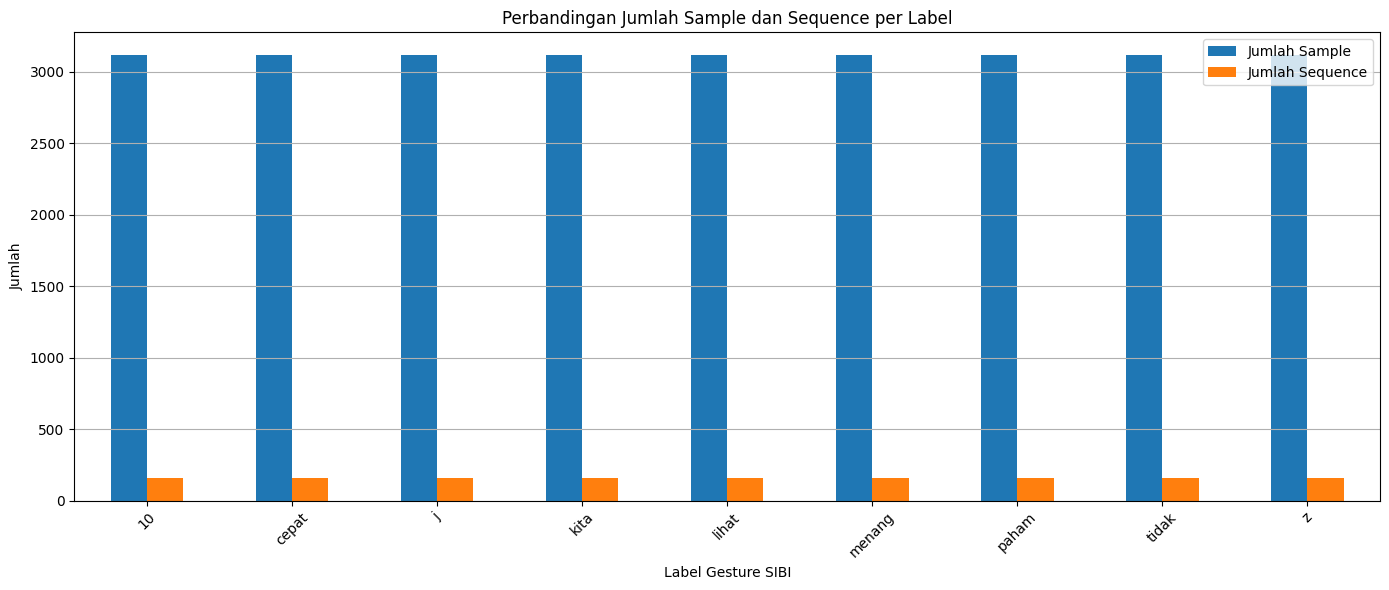

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Baca dataset
df = pd.read_csv('csv/dinamic/preprocessed_v1.csv')

# Hitung jumlah sample (frame) per label
jumlah_sample_per_label = df['Label'].value_counts().sort_index()

# Hitung jumlah sequence unik per label
jumlah_sequence_per_label = df.groupby('Label')['sequence'].nunique().sort_index()

# Gabungkan menjadi satu DataFrame
tabel_ringkasan = pd.DataFrame({
    'Jumlah Sample': jumlah_sample_per_label,
    'Jumlah Sequence': jumlah_sequence_per_label
}).reset_index().rename(columns={'index': 'Label'})

# Visualisasi
fig, ax = plt.subplots(figsize=(14, 6))

# Buat dua bar di samping: jumlah sample dan jumlah sequence
tabel_ringkasan_plot = tabel_ringkasan.set_index('Label')
tabel_ringkasan_plot.plot(kind='bar', ax=ax)

plt.title('Perbandingan Jumlah Sample dan Sequence per Label')
plt.xlabel('Label Gesture SIBI')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.legend(["Jumlah Sample", "Jumlah Sequence"])
plt.tight_layout()
plt.grid(axis='y')



## EXTRACT VIDIO

In [ ]:

def feature_extraction_3(image, data, target, label, data_separated, i, next_data):
    global X_before, Y_before

    # Konversi ke RGB untuk MediaPipe
    frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    
    # Deteksi tangan
    detection_result = detector.detect(mp_image)
    
    if not detection_result.hand_landmarks:
       
   
        
        # Jika tidak ada tangan terdeteksi, isi row_data dengan NaN
        row_data = {f"X{idx}": np.nan for idx in range(21)}
        row_data.update({f"Y{idx}": np.nan for idx in range(21)})
        row_data.update({f"Z{idx}": np.nan for idx in range(21)})

        row_data['timestep'] = i
        row_data["Label"] = target
        row_data["sequence"] = int(label + next_data)  # Label tetap "a"

        data.append(row_data)
        data_separated.append(row_data)
        

    # Jika tangan terdeteksi, ekstrak koordinat tangan
    for hand_idx, hand in enumerate(detection_result.hand_landmarks):
        x_coords = []
        y_coords = []
        z_coords = []
        
        # Ekstrak semua titik koordinat
        nilai_X = np.array([landmark.x for landmark in hand])
        nilai_Y = np.array([landmark.y for landmark in hand])
        nilai_Z = np.array([landmark.z for landmark in hand])
        
        # Simpan koordinat X, Y, Z dalam row_data
        row_data = {f"X{idx}": x for idx, x in zip(range(21), nilai_X)}
        row_data.update({f"Y{idx}": y for idx, y in zip(range(21), nilai_Y)})
        row_data.update({f"Z{idx}": z for idx, z in zip(range(21), nilai_Z)})

        row_data['timestep'] = i
        row_data["Label"] = target
        row_data["sequence"] = int(label + next_data)  # Label tetap "a"
        
        data.append(row_data)
        data_separated.append(row_data)

    return data, data_separated

In [ ]:
import cv2
import os
import mediapipe as mp
import pandas as pd
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import time
# Initialize MediaPipe hand landmarker
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=2,
    running_mode=vision.RunningMode.IMAGE  # Gunakan mode gambar
)
detector = vision.HandLandmarker.create_from_options(options)

data_separated = []
X_before, Y_before = 0, 0
data = []
next_data = 0
allDurasi=[]
# Mendapatkan semua folder (target) di dalam folder 'video2'
video_path = "video2"

allTarget = [f for f in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, f)) and not f.startswith('.')] # Hanya ambil []
allTarget=['cepat','lihat']
waktu_mulai = time.time()
for k, target in enumerate(allTarget):
    mulai = time.time()
    video_folder_path = os.path.join(video_path, target)
    
    # Ambil semua file mp4 di dalam folder target
    video_files = sorted([f for f in os.listdir(video_folder_path) if f.endswith('.mp4') and not f.startswith('.')], key=lambda x: int(x.split('.')[0]))[:95]

    # Proses setiap file video dalam folder target
    for video_index, video_file in enumerate(video_files):
        video_file_path = os.path.join(video_folder_path, video_file)

        # Buka video
        cap = cv2.VideoCapture(video_file_path)

        # Periksa apakah video berhasil dibuka
        if not cap.isOpened():
            continue

     

        detected_frames = []  # List untuk menyimpan frame yang terdeteksi tangan
        frame_count = 0

        print( video_file_path)
        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Keluar jika video selesai

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
            # Deteksi tangan
            detection_result = detector.detect(mp_image)

            # Ekstraksi fitur jika tangan terdeteksi
            data, data_separated = feature_extraction_3(frame, data, target, video_index, data_separated, frame_count, next_data)
         
            frame_count += 1

        cap.release()

    # Simpan data yang telah diproses ke dalam file CSV untuk setiap target
    data_separated_df = pd.DataFrame(data_separated)
#     df_before = pd.read_csv(f'csv_separated/dinamic/raw/{target}.csv')



# # Gabungkan secara vertikal (baris)
#     combined_df = pd.concat([df_before, data_separated_df], ignore_index=True)
    # data_separated_df.to_csv(f'csv_separated/{type_data}/raw/{target}.csv', index=False)
    allDurasi.append((f' Durasi ekstraksi Label {target} {time.time()-mulai} Detik'))
    data_separated = []  # Reset data_separated untuk target berikutnya

print("Proses selesai, frame-frame telah disimpan.")
print(f'Selesai dengan Durasi {(time.time()-waktu_mulai)*5} Detik')

I0000 00:00:1749553214.860105   31885 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1749553214.863583   35092 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1749553214.921835   35094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749553214.958635   35105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


video2/cepat/1.mp4
video2/cepat/2.mp4
video2/cepat/3.mp4
video2/cepat/4.mp4
video2/cepat/5.mp4
video2/cepat/6.mp4
video2/cepat/7.mp4
video2/cepat/8.mp4
video2/cepat/9.mp4
video2/cepat/10.mp4
video2/cepat/11.mp4
video2/cepat/12.mp4
video2/cepat/13.mp4
video2/cepat/14.mp4
video2/cepat/15.mp4
video2/cepat/16.mp4
video2/cepat/17.mp4
video2/cepat/18.mp4
video2/cepat/19.mp4
video2/cepat/20.mp4
video2/cepat/21.mp4
video2/cepat/22.mp4
video2/cepat/23.mp4
video2/cepat/24.mp4
video2/cepat/25.mp4
video2/cepat/26.mp4
video2/cepat/27.mp4
video2/cepat/28.mp4
video2/cepat/29.mp4
video2/cepat/30.mp4
video2/cepat/31.mp4
video2/cepat/32.mp4
video2/cepat/33.mp4
video2/cepat/34.mp4
video2/cepat/35.mp4
video2/cepat/36.mp4
video2/cepat/37.mp4
video2/cepat/38.mp4
video2/cepat/39.mp4
video2/cepat/40.mp4
video2/cepat/41.mp4
video2/cepat/42.mp4
video2/cepat/43.mp4
video2/cepat/44.mp4
video2/cepat/45.mp4
video2/cepat/46.mp4
video2/cepat/47.mp4
video2/cepat/48.mp4
video2/cepat/49.mp4
video2/cepat/50.mp4
video2/ce

## COMBINED I
COMBINE VERTICAL FILE CSV DENGAN LABEL YANG BERBEDA

In [ ]:
import pandas as pd
import glob

# Path tempat file CSV berada
path = 'csv_separated/dinamic/trim/*.csv'

# Dapatkan daftar semua file CSV
all_files = glob.glob(path)

# Gabungkan semua CSV ke dalam satu DataFrame
df_combined = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Simpan hasil gabungan ke file CSV baru (opsional)
df_combined.to_csv('csv/dinamic/trimmed1.csv', index=False)

# Tampilkan DataFrame
df_combined.head()


,Xl0,Xl1,Xl2,Xl3,Xl4,Xl5,Xl6,Xl7,Xl8,Xl9,...,Yh1,Xh2,Yh2,Xh3,Yh3,Xh4,Yh4,timestep,sequence,Label
0,0.423971,0.458554,0.495092,0.504643,0.482616,0.492133,0.520313,0.539522,0.551061,0.453537,...,0.404167,0.818750,0.404167,0.560937,0.745833,0.818750,0.745833,0,0,z
1,0.421186,0.459569,0.494304,0.506389,0.486263,0.493886,0.521851,0.540357,0.551448,0.454164,...,0.406250,0.815625,0.406250,0.560937,0.745833,0.815625,0.745833,1,0,z
2,0.418564,0.457584,0.492729,0.503995,0.483703,0.494430,0.522954,0.540705,0.550908,0.455241,...,0.406250,0.815625,0.406250,0.559375,0.747917,0.815625,0.747917,2,0,z
3,0.418287,0.458291,0.494655,0.506071,0.485014,0.495950,0.524722,0.542420,0.552561,0.456176,...,0.404167,0.818750,0.404167,0.559375,0.750000,0.818750,0.750000,3,0,z
4,0.418677,0.458367,0.493734,0.501177,0.478888,0.491364,0.518468,0.534973,0.545386,0.452531,...,0.406250,0.823438,0.406250,0.564063,0.750000,0.823438,0.750000,4,0,z


## DIFFERENCE 

In [ ]:
# Fungsi untuk mengurangi nilai dari baris timestep n dengan timestep n-1 untuk kolom X dan Y
# df= pd.read_csv('csv/dinamic/raw.csv')
def adjust_timestep_values(df):
    # Memproses setiap grup berdasarkan 'Label' dan 'Sub 2'
    for (label, sub2), group in df.groupby(['Label', 'sequence']):
        # Mengurutkan berdasarkan 'timestep' jika diperlukan
        group = group.sort_values(by='timestep')
        
        # Loop untuk kolom X dan Y (misalnya X1, X2, ..., X21 dan Y1, Y2, ..., Y21)
        for i in range(21):  # Kolom X1 sampai X21 dan Y1 sampai Y21
            # Kolom X
            x_col = f'X{i}'
            # Kolom Y
            y_col = f'Y{i}'
            x_diff_col = f'diffX{i}'
            y_diff_col = f'diffY{i}'
            
            # Mengurangi nilai timestep n dengan timestep n-1
            group[x_diff_col] = group[x_col].diff().dropna()  # Menggunakan diff untuk menghitung selisih
            group[y_diff_col] = group[y_col].diff().dropna()
        
        # Menyimpan kembali hasil perubahan ke dataframe utama
        df.loc[group.index, group.columns] = group
    
    return df

# Terapkan perubahan pada dataframe
adjusted_df = adjust_timestep_values(df)

## TRIMMED

In [ ]:
import numpy as np
# df=pd.read_csv(f'csv/dinamic/trim2.csv')
def trim_and_reset_timestep(df, target_length=5):
    trimmed_data = []
    for (seq, label), group in df.groupby(['sequence', 'Label']):
        group_sorted = group.sort_values('timestep')
        n = len(group_sorted)
        if n <= target_length:
            trimmed = group_sorted.copy()
        else:
            indices = np.round(np.linspace(0, n - 1, target_length)).astype(int)
            trimmed = group_sorted.iloc[indices].copy()
        trimmed['timestep'] = np.arange(len(trimmed))
        trimmed_data.append(trimmed)
    return pd.concat(trimmed_data).reset_index(drop=True)
# df = pd.read_csv(f"csv/{type_data}/filter.csv")
df = trim_and_reset_timestep(df, target_length=20)

## Select Feature

## NORMALISASI HEAD KEPALA

In [ ]:
import pandas as pd

# Baca data
# df = pd.read_csv('csv/dinamic/trimmed3.csv')

# Ambil kolom tangan kiri
x_cols = [col for col in df.columns if col.startswith('Xl')]
y_cols = [col for col in df.columns if col.startswith('Yl')]

# Sort untuk memastikan urutan stabil
df = df.sort_values(by=['Label', 'sequence', 'timestep']).reset_index(drop=True)

# Proses setiap baris
for idx, row in df.iterrows():
    label = row['Label']
    seq = row['sequence']

    # Ambil baris acuan (timestep == 0)
    ref_row = df[(df['Label'] == label) & (df['sequence'] == seq) & (df['timestep'] == 0)]
    if ref_row.empty:
        continue  # Kalau tidak ada acuan, lewati

    ref_row = ref_row.iloc[0]

    # Hitung midpoint Xh dan Yh (dan normalisasi)
    xh_mid = (ref_row['Xh1'] + ref_row['Xh2']) / (2 )
    yh_mid = (ref_row['Yh1'] + ref_row['Yh3']) / (2 )

    # Koreksi tangan kiri
    for col in x_cols:
        df.at[idx, col] = df.at[idx, col] - xh_mid
    for col in y_cols:
        df.at[idx, col] = df.at[idx, col] - yh_mid

print("✅ Semua baris berhasil dikoreksi terhadap Xh/Yh pada timestep 0 dari sequence dan label yang sama.")


✅ Semua baris berhasil dikoreksi terhadap Xh/Yh pada timestep 0 dari sequence dan label yang sama.


In [ ]:
df

,Xl0,Xl1,Xl2,Xl3,Xl4,Xl5,Xl6,Xl7,Xl8,Xl9,...,Yh1,Xh2,Yh2,Xh3,Yh3,Xh4,Yh4,timestep,sequence,Label
0,-0.320788,-0.258575,-0.203437,-0.183255,-0.186856,-0.224427,-0.209142,-0.227059,-0.236451,-0.256912,...,0.152083,0.837500,0.152083,0.570312,0.508333,0.837500,0.508333,0,0,10
1,-0.317649,-0.256928,-0.202650,-0.184201,-0.190676,-0.226594,-0.208900,-0.224893,-0.234617,-0.256658,...,0.152083,0.835938,0.152083,0.570312,0.506250,0.835938,0.506250,1,0,10
2,-0.315129,-0.255131,-0.202886,-0.183863,-0.190810,-0.228725,-0.210849,-0.226188,-0.236018,-0.258599,...,0.147917,0.835938,0.147917,0.571875,0.500000,0.835938,0.500000,2,0,10
3,-0.314844,-0.255556,-0.203273,-0.185355,-0.190740,-0.229297,-0.209740,-0.226910,-0.236701,-0.259444,...,0.156250,0.832812,0.156250,0.573438,0.500000,0.832812,0.500000,3,0,10
4,-0.315821,-0.255797,-0.205215,-0.188322,-0.192177,-0.230988,-0.210930,-0.225947,-0.237291,-0.262014,...,0.160417,0.829688,0.160417,0.575000,0.502083,0.829688,0.502083,4,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,-0.402879,-0.450604,-0.471615,-0.463114,-0.427843,-0.441371,-0.412693,-0.420679,-0.428111,-0.398643,...,0.227650,0.769574,0.227650,0.484688,0.607477,0.769574,0.607477,15,155,10
3116,-0.398455,-0.449494,-0.476987,-0.472458,-0.436586,-0.439414,-0.419564,-0.429574,-0.435964,-0.397197,...,0.206102,0.765515,0.206102,0.471136,0.598588,0.765515,0.598588,16,155,10
3117,-0.397561,-0.451665,-0.482866,-0.478967,-0.443452,-0.440218,-0.428472,-0.439917,-0.444000,-0.397656,...,0.200582,0.758718,0.200582,0.458974,0.600221,0.758718,0.600221,17,155,10
3118,-0.396791,-0.451938,-0.485051,-0.482535,-0.447114,-0.440430,-0.433328,-0.445379,-0.448219,-0.398006,...,0.203023,0.746695,0.203023,0.452995,0.594612,0.746695,0.594612,18,155,10


## Normalisasi Jika NIlai Koordinat kepala sebelumnya dikali Panjang dan Lebar Frame

In [ ]:
import pandas as pd
import os

# Path ke folder csv
folder_path = 'csv_separated/dinamic/trim/'

# Loop semua file .csv di folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)

        # Baca CSV
        df = pd.read_csv(file_path)

        # Temukan kolom-kolom yang dimaksud
        xh_cols = [col for col in df.columns if col.startswith('Xh')]
        yh_cols = [col for col in df.columns if col.startswith('Yh')]

        # Bagi sesuai ketentuan
        df[xh_cols] = df[xh_cols] / 640
        df[yh_cols] = df[yh_cols] / 480

        # Simpan kembali (overwrite)
        df.to_csv(file_path, index=False)

        print(f"Selesai proses: {filename}")


Selesai proses: z.csv
Selesai proses: j.csv
Selesai proses: cepat.csv
Selesai proses: 10.csv
Selesai proses: lihat.csv
Selesai proses: kita.csv
Selesai proses: paham.csv
Selesai proses: tidak.csv
Selesai proses: menang.csv


## MOVE KOLOM timestep, Label ,Sequence ke 3 terakhir

In [ ]:
def pindahkan_kolom_terakhir(df):
    # Tentukan nama kolom yang mau dipindah ke belakang
    kolom_akhir = ['timestep', 'Label', 'sequence']
    
    # Ambil semua kolom yang bukan target
    kolom_awal = [col for col in df.columns if col not in kolom_akhir]
    
    # Gabungkan ulang dengan urutan baru: kolom lain dulu, lalu kolom_akhir
    df = df[kolom_awal + kolom_akhir]
    return df

# Contoh pemakaian:
df = pindahkan_kolom_terakhir(df)
df


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Yn14,Yn15,Yn16,Yn17,Yn18,Yn19,Yn20,timestep,Label,sequence
0,0.355787,0.399531,0.415057,0.409214,0.402083,0.379796,0.387346,0.396464,0.392931,0.351179,...,0.640621,1.176079,1.285996,1.070746,0.942802,1.283846,1.368570,0,10,0
1,0.357829,0.400369,0.415992,0.410457,0.402759,0.379422,0.386584,0.395473,0.391010,0.350996,...,0.664048,1.202006,1.302656,1.093701,0.960537,1.301918,1.383181,1,10,0
2,0.361326,0.404876,0.420744,0.415528,0.408486,0.385334,0.392179,0.400853,0.397034,0.356181,...,0.648176,1.170450,1.265706,1.061832,0.933634,1.267244,1.339208,2,10,0
3,0.362100,0.408426,0.425759,0.419535,0.411548,0.389938,0.398685,0.406411,0.402768,0.360665,...,0.625416,1.088856,1.244539,1.055754,0.941777,1.244294,1.360634,3,10,0
4,0.365094,0.413905,0.432653,0.425275,0.416440,0.388279,0.411809,0.420035,0.416497,0.359945,...,0.730931,1.091756,1.297940,1.065034,1.059863,1.302799,1.441763,4,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17095,0.379415,0.425283,0.459137,0.475569,0.477894,0.443054,0.456795,0.469046,0.476445,0.418181,...,0.640666,0.708776,0.674103,0.518515,0.800892,0.830194,0.751181,15,z,94
17096,0.332702,0.368111,0.390813,0.374778,0.344263,0.338828,0.345845,0.351892,0.337822,0.303902,...,0.867508,1.019644,0.830592,0.600100,1.044232,1.146624,1.005624,16,z,94
17097,0.312595,0.348672,0.372172,0.365111,0.342232,0.313393,0.302933,0.297734,0.281563,0.279722,...,0.900995,1.013026,0.814261,0.605909,1.010839,1.074737,0.953556,17,z,94
17098,0.299592,0.321339,0.325472,0.304746,0.274380,0.279277,0.242870,0.215099,0.185308,0.244455,...,0.936393,1.038573,0.867069,0.566241,0.993554,1.102275,1.007858,18,z,94


In [ ]:
df_full = pd.read_csv(f'csv/{type_data}/trimmed2.csv')
[col for col in df_full.columns if col.startswith('Zl')]


['Zl0',
 'Zl1',
 'Zl2',
 'Zl3',
 'Zl4',
 'Zl5',
 'Zl6',
 'Zl7',
 'Zl8',
 'Zl9',
 'Zl10',
 'Zl11',
 'Zl12',
 'Zl13',
 'Zl14',
 'Zl15',
 'Zl16',
 'Zl17',
 'Zl18',
 'Zl19',
 'Zl20']

## TensorFlow Without CUDNN

In [ ]:
import tensorflow as tf
import os
import numpy as np
import time

print("\n--- Program 2: Mengatur TensorFlow untuk Menggunakan CPU (Tanpa cuDNN) ---")

# Menonaktifkan GPU secara eksplisit
# Variabel lingkungan ini harus diatur SEBELUM TensorFlow menginisialisasi perangkatnya.
# Jika Anda menjalankan ini di lingkungan notebook (seperti Colab atau Jupyter),
# Anda mungkin perlu me-restart runtime/kernel setelah mengatur variabel ini
# untuk memastikan TensorFlow melihat perubahan.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("\nWARNING: GPU masih terdeteksi meskipun 'CUDA_VISIBLE_DEVICES' diset '-1'.")
    print("Ini bisa terjadi jika Anda tidak me-restart runtime/kernel setelah mengatur variabel lingkungan.")
    print("Untuk memastikan CPU digunakan, silakan restart kernel/runtime Anda.")
else:
    print("\nTidak ada GPU yang terdeteksi. TensorFlow akan berjalan di CPU.")
    print("cuDNN tidak akan digunakan.")

# --- Verifikasi Perangkat yang Digunakan ---
print("\n--- Verifikasi Perangkat Saat Ini ---")
print("Perangkat Logika TensorFlow:")
for device in tf.config.list_logical_devices():
    print(f"- {device.name} ({device.device_type})")

# Menjalankan operasi sederhana dan melihat log (verbose)
print("\nMenjalankan operasi sederhana untuk verifikasi...")
a = tf.random.normal([2, 2])
b = tf.random.normal([2, 2])

start_time = time.time()
c = tf.matmul(a, b)
end_time = time.time()

print(f"Hasil operasi matriks:\n{c.numpy()}")
print(f"Waktu komputasi: {end_time - start_time:.4f} detik")

# Anda akan melihat bahwa operasi dijalankan di CPU.
print("\nPeriksa output di atas. Anda seharusnya melihat 'CPU' di log eksekusi operasi.")


# --- Contoh Pelatihan Model Sederhana ---
print("\n--- Contoh Pelatihan Model Sederhana di Perangkat Aktif ---")
# Buat data dummy
X = np.random.rand(100, 10).astype(np.float32)
y = np.random.randint(0, 2, 100).astype(np.float32)

# Bangun model sederhana
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model
print("Memulai pelatihan model...")
start_train_time = time.time()
model.fit(X, y, epochs=5, verbose=0)
end_train_time = time.time()
print(f"Pelatihan model selesai dalam {end_train_time - start_train_time:.4f} detik.")

print("\nProgram 2 selesai.")

2025-07-02 23:10:08.438947: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 23:10:08.448999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751472608.460941   44491 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751472608.464376   44491 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751472608.473099   44491 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


--- Program 2: Mengatur TensorFlow untuk Menggunakan CPU (Tanpa cuDNN) ---

Tidak ada GPU yang terdeteksi. TensorFlow akan berjalan di CPU.
cuDNN tidak akan digunakan.

--- Verifikasi Perangkat Saat Ini ---
Perangkat Logika TensorFlow:
- /device:CPU:0 (CPU)

Menjalankan operasi sederhana untuk verifikasi...
Hasil operasi matriks:
[[-2.5621243  -2.3925292 ]
 [ 2.041735    0.58672416]]
Waktu komputasi: 0.0118 detik

Periksa output di atas. Anda seharusnya melihat 'CPU' di log eksekusi operasi.

--- Contoh Pelatihan Model Sederhana di Perangkat Aktif ---
Memulai pelatihan model...


2025-07-02 23:10:11.871769: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-02 23:10:11.871794: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-07-02 23:10:11.871798: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-07-02 23:10:11.871801: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-02 23:10:11.871804: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: salamanca
2025-07-02 23:10:11.871806: I external/local_xla/xla/stream_executor/cuda/cud

Pelatihan model selesai dalam 0.6890 detik.

Program 2 selesai.


In [ ]:
import pandas as pd
pd.read_csv(f'csv/dinamic/trimmed2.csv')


,Xl0,Xl1,Xl2,Xl3,Xl4,Xl5,Xl6,Xl7,Xl8,Xl9,...,Yh1,Xh2,Yh2,Xh3,Yh3,Xh4,Yh4,timestep,sequence,Label
0,-0.320788,-0.258575,-0.203437,-0.183255,-0.186856,-0.224427,-0.209142,-0.227059,-0.236451,-0.256912,...,0.152083,0.837500,0.152083,0.570312,0.508333,0.837500,0.508333,0,0,10
1,-0.317649,-0.256928,-0.202650,-0.184201,-0.190676,-0.226594,-0.208900,-0.224893,-0.234617,-0.256658,...,0.152083,0.835938,0.152083,0.570312,0.506250,0.835938,0.506250,1,0,10
2,-0.315129,-0.255131,-0.202886,-0.183863,-0.190810,-0.228725,-0.210849,-0.226188,-0.236018,-0.258599,...,0.147917,0.835938,0.147917,0.571875,0.500000,0.835938,0.500000,2,0,10
3,-0.314844,-0.255556,-0.203273,-0.185355,-0.190740,-0.229297,-0.209740,-0.226910,-0.236701,-0.259444,...,0.156250,0.832812,0.156250,0.573438,0.500000,0.832812,0.500000,3,0,10
4,-0.315821,-0.255797,-0.205215,-0.188322,-0.192177,-0.230988,-0.210930,-0.225947,-0.237291,-0.262014,...,0.160417,0.829688,0.160417,0.575000,0.502083,0.829688,0.502083,4,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,-0.425215,-0.390777,-0.365888,-0.366873,-0.387613,-0.421500,-0.439415,-0.455850,-0.476746,-0.465925,...,0.196585,0.782163,0.196585,0.522820,0.542369,0.782163,0.542369,15,155,z
28076,-0.446677,-0.411006,-0.394934,-0.424495,-0.459838,-0.461099,-0.495022,-0.523877,-0.552898,-0.509377,...,0.200173,0.779149,0.200173,0.522985,0.541724,0.779149,0.541724,16,155,z
28077,-0.457735,-0.415094,-0.399633,-0.434861,-0.479222,-0.469515,-0.497111,-0.526794,-0.560017,-0.519987,...,0.204571,0.780718,0.204571,0.520456,0.551586,0.780718,0.551586,17,155,z
28078,-0.456643,-0.416536,-0.401369,-0.436716,-0.480317,-0.469907,-0.497641,-0.525936,-0.558588,-0.521013,...,0.208905,0.777862,0.208905,0.520837,0.551605,0.777862,0.551605,18,155,z


## SELEKSI PARAMETER

In [3]:
import pandas as pd

type_data = 'dinamic'  # atau 'static' sesuai kebutuhan

# Baca seluruh file
df_full = pd.read_csv(f'csv/{type_data}/preprocessed_v1.csv')

x_cols = [col for col in df_full.columns if col.startswith('Xl')]
y_cols = [col for col in df_full.columns if col.startswith('Yl')]
z_cols = ['Zl0','Zl4','Zl8','Zl12']

selected_cols = x_cols + y_cols + z_cols+ ['timestep', 'sequence', 'Label']

# Buat DataFrame baru hanya dengan kolom terpilih
df = df_full[selected_cols].copy()

print("✅ Kolom berhasil diseleksi:")
print(df.head())


✅ Kolom berhasil diseleksi:
        Xl0       Xl1       Xl2       Xl3       Xl4       Xl5       Xl6  \
0 -0.320788 -0.258575 -0.203437 -0.183255 -0.186856 -0.224427 -0.209142   
1 -0.317649 -0.256928 -0.202650 -0.184201 -0.190676 -0.226594 -0.208900   
2 -0.315129 -0.255131 -0.202886 -0.183863 -0.190810 -0.228725 -0.210849   
3 -0.314844 -0.255556 -0.203273 -0.185355 -0.190740 -0.229297 -0.209740   
4 -0.315821 -0.255797 -0.205215 -0.188322 -0.192177 -0.230988 -0.210930   

        Xl7       Xl8       Xl9  ...      Yl18      Yl19      Yl20  \
0 -0.227059 -0.236451 -0.256912  ... -0.157164 -0.108252 -0.099043   
1 -0.224893 -0.234617 -0.256658  ... -0.159350 -0.109743 -0.097896   
2 -0.226188 -0.236018 -0.258599  ... -0.158083 -0.108654 -0.095848   
3 -0.226910 -0.236701 -0.259444  ... -0.156701 -0.107187 -0.096030   
4 -0.225947 -0.237291 -0.262014  ... -0.153071 -0.102159 -0.088768   

            Zl0       Zl4       Zl8      Zl12  timestep  sequence  Label  
0 -3.437496e-07 -0.009810

In [4]:
df

,Xl0,Xl1,Xl2,Xl3,Xl4,Xl5,Xl6,Xl7,Xl8,Xl9,...,Yl18,Yl19,Yl20,Zl0,Zl4,Zl8,Zl12,timestep,sequence,Label
0,-0.320788,-0.258575,-0.203437,-0.183255,-0.186856,-0.224427,-0.209142,-0.227059,-0.236451,-0.256912,...,-0.157164,-0.108252,-0.099043,-3.437496e-07,-0.009810,-0.030724,-0.025654,0,0,10
1,-0.317649,-0.256928,-0.202650,-0.184201,-0.190676,-0.226594,-0.208900,-0.224893,-0.234617,-0.256658,...,-0.159350,-0.109743,-0.097896,-3.109919e-07,-0.013814,-0.025427,-0.013548,1,0,10
2,-0.315129,-0.255131,-0.202886,-0.183863,-0.190810,-0.228725,-0.210849,-0.226188,-0.236018,-0.258599,...,-0.158083,-0.108654,-0.095848,-3.142167e-07,-0.012756,-0.025505,-0.016223,2,0,10
3,-0.314844,-0.255556,-0.203273,-0.185355,-0.190740,-0.229297,-0.209740,-0.226910,-0.236701,-0.259444,...,-0.156701,-0.107187,-0.096030,-3.299857e-07,-0.011698,-0.024054,-0.013887,3,0,10
4,-0.315821,-0.255797,-0.205215,-0.188322,-0.192177,-0.230988,-0.210930,-0.225947,-0.237291,-0.262014,...,-0.153071,-0.102159,-0.088768,-3.277894e-07,-0.009470,-0.022129,-0.013825,4,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,-0.425215,-0.390777,-0.365888,-0.366873,-0.387613,-0.421500,-0.439415,-0.455850,-0.476746,-0.465925,...,0.404688,0.423327,0.408450,4.717168e-08,-0.147466,-0.192109,-0.132100,15,155,z
28076,-0.446677,-0.411006,-0.394934,-0.424495,-0.459838,-0.461099,-0.495022,-0.523877,-0.552898,-0.509377,...,0.407760,0.420447,0.402498,1.125010e-08,-0.098482,-0.151039,-0.103069,16,155,z
28077,-0.457735,-0.415094,-0.399633,-0.434861,-0.479222,-0.469515,-0.497111,-0.526794,-0.560017,-0.519987,...,0.411594,0.421421,0.400919,4.921970e-08,-0.118797,-0.184065,-0.119031,17,155,z
28078,-0.456643,-0.416536,-0.401369,-0.436716,-0.480317,-0.469907,-0.497641,-0.525936,-0.558588,-0.521013,...,0.412231,0.420865,0.399848,3.127362e-08,-0.112678,-0.169559,-0.109502,18,155,z


In [2]:
df

,Xl0,Xl1,Xl2,Xl3,Xl4,Xl5,Xl6,Xl7,Xl8,Xl9,...,Yl18,Yl19,Yl20,Zl0,Zl4,Zl8,Zl12,timestep,sequence,Label
0,-0.320788,-0.258575,-0.203437,-0.183255,-0.186856,-0.224427,-0.209142,-0.227059,-0.236451,-0.256912,...,-0.157164,-0.108252,-0.099043,-3.437496e-07,-0.009810,-0.030724,-0.025654,0,0,10
1,-0.317649,-0.256928,-0.202650,-0.184201,-0.190676,-0.226594,-0.208900,-0.224893,-0.234617,-0.256658,...,-0.159350,-0.109743,-0.097896,-3.109919e-07,-0.013814,-0.025427,-0.013548,1,0,10
2,-0.315129,-0.255131,-0.202886,-0.183863,-0.190810,-0.228725,-0.210849,-0.226188,-0.236018,-0.258599,...,-0.158083,-0.108654,-0.095848,-3.142167e-07,-0.012756,-0.025505,-0.016223,2,0,10
3,-0.314844,-0.255556,-0.203273,-0.185355,-0.190740,-0.229297,-0.209740,-0.226910,-0.236701,-0.259444,...,-0.156701,-0.107187,-0.096030,-3.299857e-07,-0.011698,-0.024054,-0.013887,3,0,10
4,-0.315821,-0.255797,-0.205215,-0.188322,-0.192177,-0.230988,-0.210930,-0.225947,-0.237291,-0.262014,...,-0.153071,-0.102159,-0.088768,-3.277894e-07,-0.009470,-0.022129,-0.013825,4,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,-0.425215,-0.390777,-0.365888,-0.366873,-0.387613,-0.421500,-0.439415,-0.455850,-0.476746,-0.465925,...,0.404688,0.423327,0.408450,4.717168e-08,-0.147466,-0.192109,-0.132100,15,155,z
28076,-0.446677,-0.411006,-0.394934,-0.424495,-0.459838,-0.461099,-0.495022,-0.523877,-0.552898,-0.509377,...,0.407760,0.420447,0.402498,1.125010e-08,-0.098482,-0.151039,-0.103069,16,155,z
28077,-0.457735,-0.415094,-0.399633,-0.434861,-0.479222,-0.469515,-0.497111,-0.526794,-0.560017,-0.519987,...,0.411594,0.421421,0.400919,4.921970e-08,-0.118797,-0.184065,-0.119031,17,155,z
28078,-0.456643,-0.416536,-0.401369,-0.436716,-0.480317,-0.469907,-0.497641,-0.525936,-0.558588,-0.521013,...,0.412231,0.420865,0.399848,3.127362e-08,-0.112678,-0.169559,-0.109502,18,155,z


## CONVERT TO ARRAY

In [2]:
import numpy as np
data_time_series = []

# df= pd.read_csv(f'csv/{type_data}/trimmed2.csv')
# Iterasi untuk setiap nilai unik di 'Label'
for i, di in enumerate(df['Label'].unique()):
    data_time_series.append([])
    
    # Iterasi untuk setiap nilai unik di 'Sub 2'
    for i2, d2 in enumerate(df['sequence'].unique()):
        data_time_series[i].append([])
        
        # Filter data berdasarkan kondisi yang benar
        filtered_data = df[(df['sequence'] == d2) & (df['Label'] == di)]
        
        # Cetak data yang sudah difilter untuk memeriksa hasil
    
        
        # Iterasi atas data yang sudah difilter
        for i3, row in filtered_data.iterrows():
            # Ambil nilai kolom pertama hingga ke-21 dan masukkan ke dalam list
            data_time_series[i][i2].append([row.iloc[:46].tolist()])

data = np.array(data_time_series)
Y_train = np.array(df['Label'].unique())
Y_train

array(['10', 'cepat', 'j', 'kita', 'lihat', 'menang', 'paham', 'tidak',
       'z'], dtype=object)

## SPLIT DATA 1

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y_train)

# Membagi data berdasarkan dimensi kedua (44)
X_train, X_test, y_train, y_test = [], [], [], []

# Menggunakan loop untuk membagi data per label
for i in range(data.shape[0]):  # iterasi untuk setiap label (4 label)
    X_label = data[i]  # Ambil data untuk label ke-i
    y_label = y_encoded [i]  # Ambil target yang sudah diencode untuk label ke-i
    
    # Split data time series (44 data menjadi 80% untuk training, 20% untuk testing)
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        X_label, 
        [y_label] * len(X_label),  # Targetnya sama untuk semua time series dalam satu label
        test_size=0.2, 
        random_state=42
    )
    
    # Append hasil split untuk label ke-i
    X_train.append(X_train_label)
    X_test.append(X_test_label)
    y_train.append(y_train_label)
    y_test.append(y_test_label)

# Mengonversi ke array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
train_sample = X_train.shape[1]
# Menampilkan bentuk hasil split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9, 76, 20, 1, 65) (9, 19, 20, 1, 65) (9, 76) (9, 19)


## SPLIT DATA 2

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y_train)

# Tempat penyimpanan hasil split
X_train, X_val, X_test = [], [], []
y_train, y_val, y_test = [], [], []

for i in range(data.shape[0]):  # per label
    X_label = data[i]
    y_label = y_encoded[i]

    # Step 1: train (80%) vs temp (20%)
    X_train_label, X_temp_label, y_train_label, y_temp_label = train_test_split(
        X_label,
        [y_label] * len(X_label),
        test_size=0.2,
        random_state=42
    )

    # Step 2: temp dipecah lagi jadi val (10%) dan test (10%)
    X_val_label, X_test_label, y_val_label, y_test_label = train_test_split(
        X_temp_label,
        y_temp_label,
        test_size=0.5,
        random_state=42
    )

    # Simpan hasil
    X_train.append(X_train_label)
    X_val.append(X_val_label)
    X_test.append(X_test_label)

    y_train.append(y_train_label)
    y_val.append(y_val_label)
    y_test.append(y_test_label)

# Gabung semua label
X_train = np.concatenate(X_train)
X_val   = np.concatenate(X_val)
X_test  = np.concatenate(X_test)

y_train = np.concatenate(y_train)
y_val   = np.concatenate(y_val)
y_test  = np.concatenate(y_test)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_val  :", y_val.shape)
print("y_test :", y_test.shape)


X_train: (1116, 20, 1, 46)
X_val  : (144, 20, 1, 46)
X_test : (144, 20, 1, 46)
y_train: (1116,)
y_val  : (144,)
y_test : (144,)


In [ ]:
X_train= X_train[:, :, :, :42]
X_val = X_val[:,:,:,:42]

In [ ]:
X_test2= X_test[:,:,:,:42]

In [ ]:
# Manual hitung loss dan akurasi
y_pred = model.predict(X_test)  # (90, 9)
from sklearn.metrics import accuracy_score, log_loss

y_true = np.argmax(y_test_one_hot, axis=1)
y_pred_label = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred_label))
print("Loss:", log_loss(y_true, y_pred))  # categorical crossentropy manual



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.8333333333333334
Loss: 0.38390068714552233


# BUAT LABEL MAP DENGAN PKL DAN DISIMPAN

In [5]:
import pickle

label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
label_map

{0: '10',
 1: 'cepat',
 2: 'j',
 3: 'kita',
 4: 'lihat',
 5: 'menang',
 6: 'paham',
 7: 'tidak',
 8: 'z'}

In [ ]:
# Simpan ke file
with open('csv/label map/dinamic.pkl', 'wb') as f:
    pickle.dump(label_map, f)


## EARLY STOPPING

In [6]:
from tensorflow.keras.callbacks import Callback

class SmartEarlyStopping(Callback):
    def __init__(self, target_acc=0.98, target_loss=0.45):
        super().__init__()
        self.target_acc = target_acc
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")
        if val_acc is not None and val_loss is not None:
            if val_acc > self.target_acc and val_loss < self.target_loss:
                print(f"\n✅ Stopping training: val_accuracy={val_acc:.4f} > {self.target_acc} "
                      f"and val_loss={val_loss:.4f} < {self.target_loss}")
                self.model.stop_training = True


2025-07-05 00:00:40.804269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 00:00:40.813759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751648440.824593   53495 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751648440.828044   53495 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751648440.837410   53495 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [9]:
X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[3])  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
X_val_reshaped = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[3])  # M
X_train_reshaped.shape

(1116, 20, 46)

## LSTM FUNDAMENTAL MODEL I

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Mengubah bentuk X_train dan X_test menjadi format yang sesuai untuk LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2],X_train.shape[4])  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
X_test_reshaped = X_test.reshape(X_test.shape[0]*X_test.shape[1],X_test.shape[2],X_test.shape[4])  # M
# X_train_reshaped = X_train.reshape(4, 35, 38 * 21)  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
# X_test_reshaped = X_test.reshape(4,9, 38* 21)  # Menggabungkan fitur 38 dan 21 menjadi 798

# Mengonversi label ke one-hot encoding (karena menggunakan categorical crossentropy)
y_train_one_hot = to_categorical(y_train, num_classes=9)
y_test_one_hot = to_categorical(y_test, num_classes=9)

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), input_shape=(X_train.shape[2],X_train.shape[4])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(9, activation='softmax')
])


# # Model LSTM untuk klasifikasi multikelas (4 label) dengan return_sequences=True
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, input_shape=(38, 21)),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Kompilasi model dengan loss function categorical_crossentropy dan metrik accuracy
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menyediakan ringkasan model
model.summary()

# Melatih model
smart_early_stopping = SmartEarlyStopping(target_acc=0.99, target_loss=0.1)

history = model.fit(
    X_train_reshaped, y_train_one_hot,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_one_hot),
    verbose=2,
    shuffle=True,
    callbacks=[smart_early_stopping]
)
# Menampilkan grafik loss dan accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


IndexError: tuple index out of range

In [ ]:
import tensorflow as tf

# 1. Definisikan model Anda (sesuai dengan yang sudah Anda miliki)
model = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'), 
        input_shape=(X_train.shape[1], X_train.shape[3], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(64, return_sequences=True, 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(9, activation='softmax')
])

# 2. Kompilasi model (pastikan ini sesuai dengan kebutuhan Anda)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Konversi ke TFLite
def convert_to_tflite(keras_model, tflite_model_path):
    # Buat converter
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    
    # Optimasi model (opsional)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Konversi model
    tflite_model = converter.convert()
    
    # Simpan model
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Model TFLite berhasil disimpan di: {tflite_model_path}")

# 4. Jalankan konversi
if __name__ == "__main__":
    # Simpan model Keras terlebih dahulu (opsional)
    model.save('my_model.h5')
    
    # Konversi ke TFLite
    convert_to_tflite(model, 'model.tflite')

## LSTM FUNDAMENTAL MODEL II

In [9]:
import tensorflow as tf
model = tf.keras.Sequential([
    # TimeDistributed agar CNN diterapkan secara independen ke setiap timestep
    # Conv1D mengharapkan input (batch, steps, channels)
    # X_train.shape[3] (42) akan menjadi 'steps'
    # Kita perlu menambahkan dimensi 'channels' secara eksplisit
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'), 
                                    input_shape=(X_train.shape[1], X_train.shape[3], 1)), # <-- Perubahan di sini: tambahkan ,1 untuk channels
    
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()), # Flatten output Conv1D sebelum masuk LSTM
    
    tf.keras.layers.LSTM(64, return_sequences=True, 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 20, 44, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 22, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 704)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,689 (811.29 KB)

 Trainable params: 207,689 (811.29 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import tensorflow as tf

# Asumsikan X_train.shape adalah (jumlah_sampel, 20, 42)
# Di mana 20 adalah timestep dan 42 adalah jumlah fitur per timestep.
# Kita tidak perlu dimensi 'channels' untuk pendekatan ini.

model = tf.keras.Sequential([
    # Lapisan ini akan mempelajari fitur spasial dari 42 landmark di setiap frame.
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(128, activation='relu'), 
        # Sesuaikan input_shape. Shape[1] adalah timesteps (20), Shape[2] adalah fitur (42).
        input_shape=(X_train.shape[1], X_train.shape[3]) 
    ),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.3)),
    
    # LSTM pertama memproses urutan fitur yang sudah "diperkaya" dari lapisan Dense.
    tf.keras.layers.LSTM(64, return_sequences=True, 
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    
    # LSTM kedua untuk meringkas seluruh sekuens.
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),

    # Lapisan output tetap sama.
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, 20, 128)        │         6,016 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,137 (266.16 KB)

 Trainable params: 68,137 (266.16 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.utils import to_categorical
X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[3])  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
X_val_reshaped = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[3])  # M
# X_train_reshaped = X_train.reshape(4, 35, 38 * 21)  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
# X_test_reshaped = X_test.reshape(4,9, 38* 21)  # Menggabungkan fitur 38 dan 21 menjadi 798

# Mengonversi label ke one-hot encoding (karena menggunakan categorical crossentropy)
y_train_one_hot = to_categorical(y_train, num_classes=9)
y_val_one_hot = to_categorical(y_val, num_classes=9)
X_train_reshaped.shape,X_val_reshaped.shape,y_train_one_hot.shape,y_val_one_hot.shape

2025-07-10 17:23:57.304596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 17:23:57.313231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752143037.324083    4777 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752143037.327589    4777 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752143037.336471    4777 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

((1116, 20, 46), (144, 20, 46), (1116, 9), (144, 9))

In [ ]:
# SKRIPSIIIII
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01),
                        input_shape=(X_train.shape[1], X_train.shape[3])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),

  
    
    tf.keras.layers.LSTM(32),  # Kurangi unit untuk hindari overfit

    tf.keras.layers.Dense(9, activation='softmax')
])

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, 20, 128)        │         6,016 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,137 (266.16 KB)

 Trainable params: 68,137 (266.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 - 3s - 79ms/step - accuracy: 0.2276 - loss: 3.5843 - val_accuracy: 0.3542 - val_loss: 3.2260
Epoch 2/20
35/35 - 0s - 14ms/step - accuracy: 0.3629 - loss: 2.9107 - val_accuracy: 0.4514 - val_loss: 2.5835
Epoch 3/20
35/35 - 0s - 10ms/step - accuracy: 0.5448 - loss: 2.3495 - val_accuracy: 0.7222 - val_loss: 1.9978
Epoch 4/20
35/35 - 1s - 16ms/step - accuracy: 0.7760 - loss: 1.7649 - val_accuracy: 0.8889 - val_loss: 1.4440
Epoch 5/20
35/35 - 0s - 11ms/step - accuracy: 0.8808 - loss: 1.3275 - val_accuracy: 0.9861 - val_loss: 1.0431
Epoch 6/20
35/35 - 0s - 11ms/step - accuracy: 0.9337 - loss: 1.0102 - val_accuracy: 0.9931 - val_loss: 0.7805
Epoch 7/20
35/35 - 0s - 13ms/step - accuracy: 0.9507 - loss: 0.8143 - val_accuracy: 0.9653 - val_loss: 0.6627
Epoch 8/20
35/35 - 0s - 12ms/step - accuracy: 0.9749 - loss: 0.6535 - val_accuracy: 0.9931 - val_loss: 0.5139
Epoch 9/20
35/35 - 0s - 13ms/step - accuracy: 0.9713 - loss: 0.5577 - val_accuracy: 0.9792 - val_loss: 0.4737
Epoch 10/2

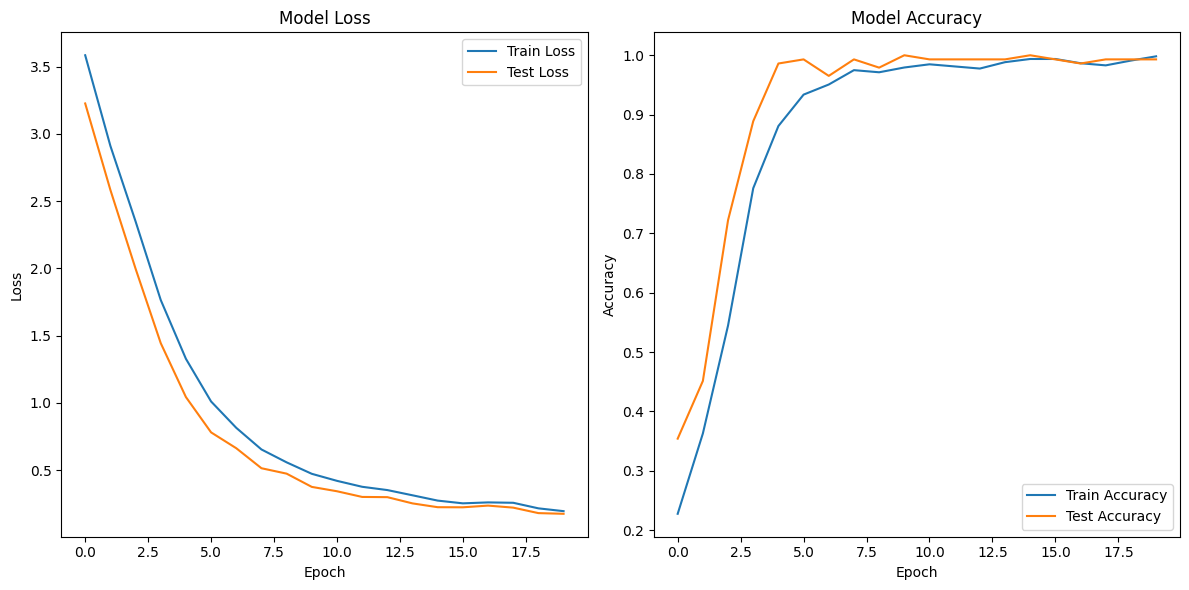

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Mengubah bentuk X_train dan X_test menjadi format yang sesuai untuk LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[3])  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
X_val_reshaped = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[3])  # M
# X_train_reshaped = X_train.reshape(4, 35, 38 * 21)  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
# X_test_reshaped = X_test.reshape(4,9, 38* 21)  # Menggabungkan fitur 38 dan 21 menjadi 798

# Mengonversi label ke one-hot encoding (karena menggunakan categorical crossentropy)
y_train_one_hot = to_categorical(y_train, num_classes=9)
y_val_one_hot = to_categorical(y_val, num_classes=9)
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(64, return_sequences=True, 
#                         kernel_regularizer=tf.keras.regularizers.l2(0.02),
#                         input_shape=(X_train.shape[1], X_train.shape[3])),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.4),

  
    
#     tf.keras.layers.LSTM(32),  # Kurangi unit untuk hindari overfit
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(9, activation='softmax')
# ])
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(64, return_sequences=True, 
#                         kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                         input_shape=(X_train.shape[1], X_train.shape[3])),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.2),

  
    
#     tf.keras.layers.LSTM(32),  # Kurangi unit untuk hindari overfit

#     tf.keras.layers.Dense(9, activation='softmax')
# ])
# Model LSTM untuk klasifikasi multikelas (4 label) dengan return_sequences=True
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, input_shape=(38, 21)),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])


# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(
#         64, 
#         return_sequences=True, 
#         activation='tanh',                        # Cell activation
#         recurrent_activation='sigmoid',           # Gate activation
#         use_bias=True,
#         unroll=True,                              # Aman untuk sequence pendek (20)
#         kernel_regularizer=tf.keras.regularizers.l2(0.01),
#         input_shape=(X_train.shape[1], X_train.shape[2])  # shape: (20, num_features)
#     ),

#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.LSTM(
#         32,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         use_bias=True,
#         unroll=True
#     ),

#     tf.keras.layers.Dense(9, activation='softmax')
# ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Kompilasi model dengan loss function categorical_crossentropy dan metrik accuracy
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menyediakan ringkasan model
model.summary()

# Melatih model
smart_early_stopping = SmartEarlyStopping(target_acc=0.99, target_loss=0.18)

history = model.fit(
    X_train_reshaped, y_train_one_hot,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_one_hot),
    verbose=2,
    shuffle=True,
    callbacks=[smart_early_stopping]
)
# Menampilkan grafik loss dan accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## LSTM FUNDAMENTAL MODEL III 

Epoch 1/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 — Train F1: 0.1544, Val F1: 0.1741
24/24 - 3s - 126ms/step - accuracy: 0.2026 - loss: 2.8486 - val_accuracy: 0.3111 - val_loss: 2.7714
Epoch 2/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 — Train F1: 0.1498, Val F1: 0.1542
24/24 - 1s - 30ms/step - accuracy: 0.3033 - loss: 2.7109 - val_accuracy: 0.2889 - val_loss: 2.6028
Epoch 3/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 — Train F1: 0.1991, Val F1: 0.2303
24/24 - 1s - 33ms/step - accuracy: 0.2915 - loss: 2.5193 - val_accuracy: 0.3333 - val_loss: 2.3483
Epoch 4/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 — Train F1: 0.3467, Val F1: 0.3466
24/24 - 1s - 30ms/step - accuracy: 0.3464 - loss: 2.2782 - val_accuracy: 0.4222 - val_loss: 2.0860
Epoch 5/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 — Train F1: 0.5535, Val F1: 0.5439
24/24 - 1s - 32ms/step - accuracy: 0.5216 - loss: 1.9979 - val_accuracy: 0.5778 - val_loss: 1.7990
Epoch 6/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6 — Train F1: 0.6819, Val F1: 0.7490
24/24 - 1s - 26ms/step - accuracy: 0.6588 - loss: 1.6849 - val_accuracy: 0.8000 - val_loss: 1.4603
Epoch 7/30


/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7 — Train F1: 0.7758, Val F1: 0.8248
24/24 - 1s - 22ms/step - accuracy: 0.7451 - loss: 1.3835 - val_accuracy: 0.8444 - val_loss: 1.1234
Epoch 8/30
Epoch 8 — Train F1: 0.8749, Val F1: 0.9313
24/24 - 1s - 31ms/step - accuracy: 0.8144 - loss: 1.1665 - val_accuracy: 0.9333 - val_loss: 0.9424
Epoch 9/30
Epoch 9 — Train F1: 0.9141, Val F1: 0.9551
24/24 - 1s - 32ms/step - accuracy: 0.8771 - loss: 0.9923 - val_accuracy: 0.9556 - val_loss: 0.8487
Epoch 10/30
Epoch 10 — Train F1: 0.9568, Val F1: 0.9776
24/24 - 1s - 33ms/step - accuracy: 0.9307 - loss: 0.8392 - val_accuracy: 0.9778 - val_loss: 0.6543
Epoch 11/30
Epoch 11 — Train F1: 0.9659, Val F1: 0.9776
24/24 - 1s - 30ms/step - accuracy: 0.9490 - loss: 0.7007 - val_accuracy: 0.9778 - val_loss: 0.5560
Epoch 12/30
Epoch 12 — Train F1: 0.9702, Val F1: 1.0000
24/24 - 1s - 31ms/step - accuracy: 0.9699 - loss: 0.6043 - val_accuracy: 1.0000 - val_loss: 0.4840
Epoch 13/30
Epoch 13 — Train F1: 0.9725, Val F1: 1.0000
24/24 - 1s - 26ms/step - accura

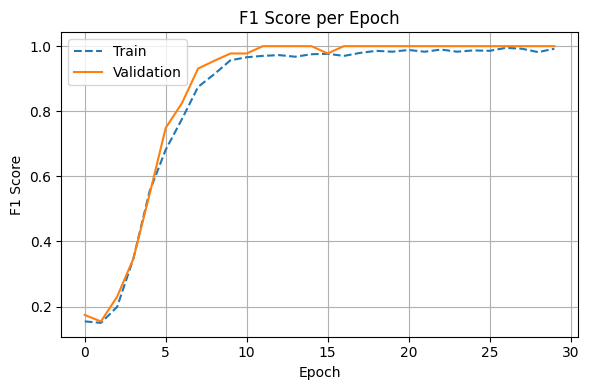

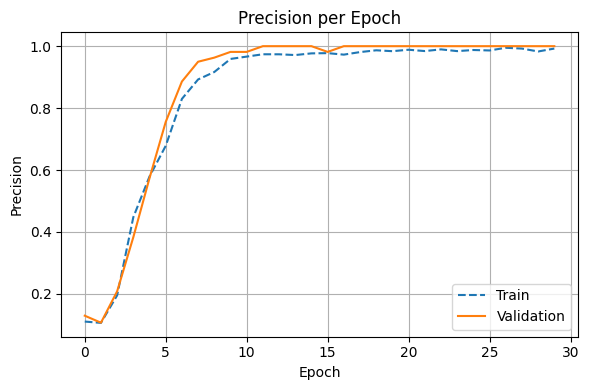

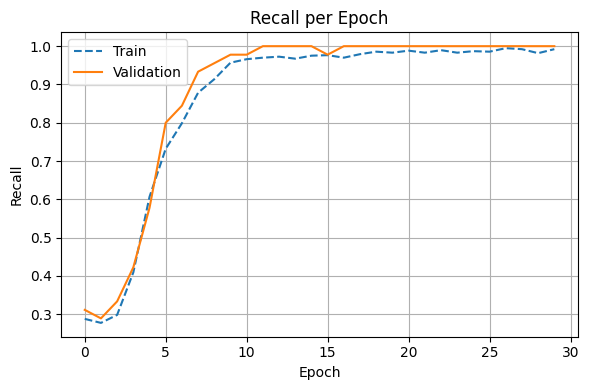

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Dummy data (ganti dengan data asli kamu)
num_classes = 9


# Reshape untuk LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[3])
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[3])

# One-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

# Callback untuk metrik
class MetricsCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s, self.train_precisions, self.train_recalls = [], [], []
        self.val_f1s, self.val_precisions, self.val_recalls = [], [], []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val_true = self.val_data
        X_train, y_train_true = self.train_data

        y_val_true = np.argmax(y_val_true, axis=1)
        y_train_true = np.argmax(y_train_true, axis=1)

        y_val_pred = np.argmax(self.model.predict(X_val, verbose=0), axis=1)
        y_train_pred = np.argmax(self.model.predict(X_train, verbose=0), axis=1)

        self.val_precisions.append(precision_score(y_val_true, y_val_pred, average='weighted'))
        self.val_recalls.append(recall_score(y_val_true, y_val_pred, average='weighted'))
        self.val_f1s.append(f1_score(y_val_true, y_val_pred, average='weighted'))

        self.train_precisions.append(precision_score(y_train_true, y_train_pred, average='weighted'))
        self.train_recalls.append(recall_score(y_train_true, y_train_pred, average='weighted'))
        self.train_f1s.append(f1_score(y_train_true, y_train_pred, average='weighted'))

        print(f"Epoch {epoch+1} — Train F1: {self.train_f1s[-1]:.4f}, Val F1: {self.val_f1s[-1]:.4f}")

# Bangun model LSTM
model = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(32, activation='relu'),
    Dropout(0.2),
    LSTM(32),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
metrics_callback = MetricsCallback(
    train_data=(X_train_reshaped, y_train_one_hot),
    val_data=(X_val_reshaped, y_val_one_hot)
)

history = model.fit(
    X_train_reshaped, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_one_hot),
    callbacks=[metrics_callback],
    verbose=2
)

# Visualisasi metrik per epoch
def plot_metric(title, train_values, val_values, ylabel):
    plt.figure(figsize=(6, 4))
    plt.plot(train_values, label='Train', linestyle='--')
    plt.plot(val_values, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("F1 Score per Epoch", metrics_callback.train_f1s, metrics_callback.val_f1s, "F1 Score")
plot_metric("Precision per Epoch", metrics_callback.train_precisions, metrics_callback.val_precisions, "Precision")
plot_metric("Recall per Epoch", metrics_callback.train_recalls, metrics_callback.val_recalls, "Recall")


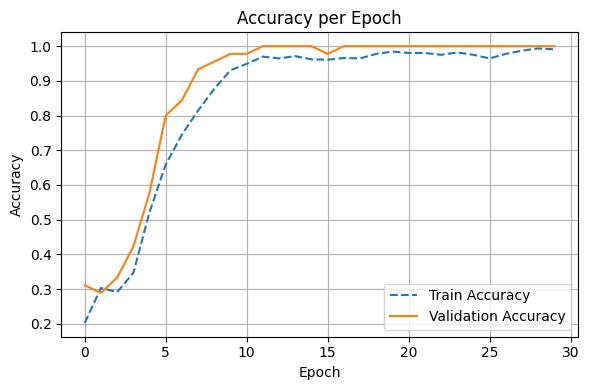

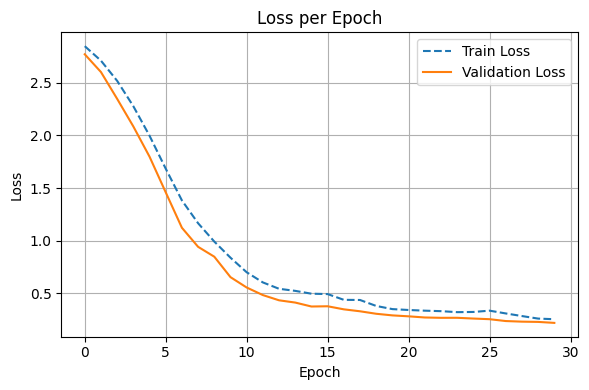

In [ ]:
# Plot Akurasi
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


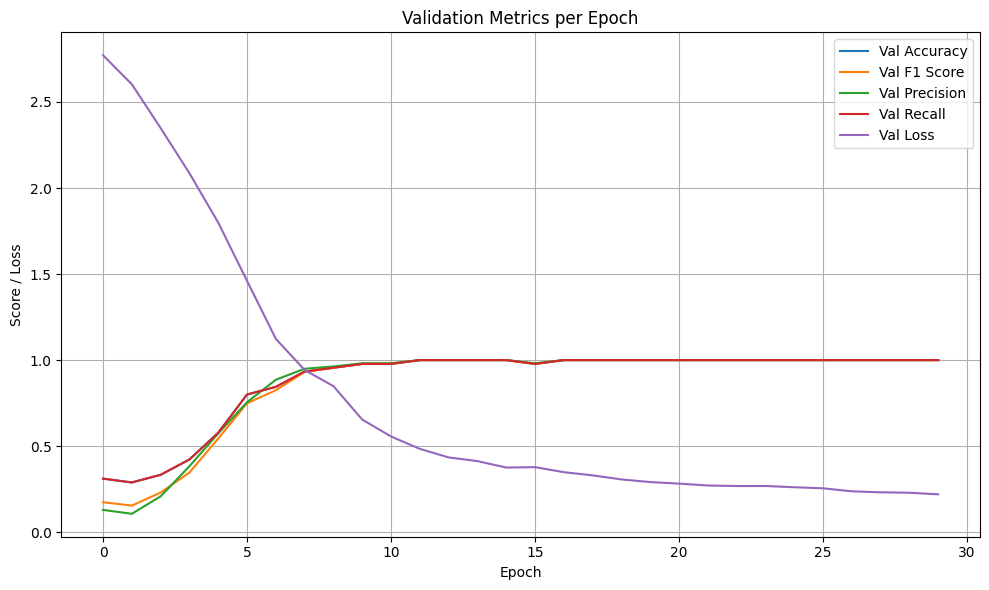

In [ ]:
plt.figure(figsize=(10, 6))

# Garis untuk setiap metrik validasi
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(metrics_callback.val_f1s, label='Val F1 Score')
plt.plot(metrics_callback.val_precisions, label='Val Precision')
plt.plot(metrics_callback.val_recalls, label='Val Recall')
plt.plot(history.history['val_loss'], label='Val Loss')

plt.title('Validation Metrics per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score / Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SAVE MODEL

In [16]:
model.save('model/dinamic/gpu.h5')

In [18]:
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[3])  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21

# X_train_reshaped = X_train.reshape(4, 35, 38 * 21)  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
# X_test_reshaped = X_test.reshape(4,9, 38* 21)  # Menggabungkan fitur 38 dan 21 menjadi 798

# Mengonversi label ke one-hot encoding (karena menggunakan categorical crossentropy)
y_test_one_hot = to_categorical(y_test, num_classes=9)


loss, acc = model.evaluate(X_test_reshaped, y_test_one_hot, verbose=1)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.1692 
Test loss: 0.1655, Test accuracy: 1.0000


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Custom TrustGate Layer
class TrustGate(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(TrustGate, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W_tau = self.add_weight(shape=(input_shape[-1], self.units),
                                     initializer='glorot_uniform',
                                     trainable=True)
        self.b_tau = self.add_weight(shape=(self.units,),
                                     initializer='zeros',
                                     trainable=True)

    def call(self, inputs):
        tau = tf.sigmoid(tf.tensordot(inputs, self.W_tau, axes=1) + self.b_tau)
        return tau * inputs

    def get_config(self):
        config = super(TrustGate, self).get_config()
        config.update({"units": self.units})
        return config

# --- Ubah Bentuk Data Sesuai ---
X_train_reshaped = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2], X_train.shape[4])
X_test_reshaped = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2], X_test.shape[4])

# One-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=9)
y_test_one_hot = to_categorical(y_test, num_classes=9)

# --- Model dengan TrustGate ---
input_dim = X_train.shape[4]
timesteps = X_train.shape[2]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(timesteps, input_dim)),
    TrustGate(units=input_dim),  # Trust Gate Layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Kompilasi
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


smart_early_stopping = SmartEarlyStopping(target_acc=0.99, target_loss=0.1)

history = model.fit(
    X_train_reshaped, y_train_one_hot,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_one_hot),
    verbose=2,
    shuffle=True,
    callbacks=[smart_early_stopping]
)

# Plot grafik hasil
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ trust_gate (TrustGate)          │ (None, 25, 46)         │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │        56,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,627 (271.98 KB)

 Trainable params: 69,627 (271.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


E0000 00:00:1746907891.005097  732033 cuda_blas.cc:193] failed to create cublas handle: the resource allocation failed
E0000 00:00:1746907891.005125  732033 cuda_blas.cc:196] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.


InternalError: Graph execution error:

Detected at node sequential_10_1/trust_gate_1/Tensordot/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3099, in _run_cell

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3303, in run_cell_async

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3486, in run_ast_nodes

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code

  File "/tmp/ipykernel_723928/1475422660.py", line 60, in <module>

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/models/sequential.py", line 221, in call

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/lalo_salamanca/Projects/p1_project_LSTM/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/tmp/ipykernel_723928/1475422660.py", line 21, in call

No blas support for stream
	 [[{{node sequential_10_1/trust_gate_1/Tensordot/MatMul}}]] [Op:__inference_multi_step_on_iterator_30446]

/tmp/ipykernel_5020/3842738443.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10',30)


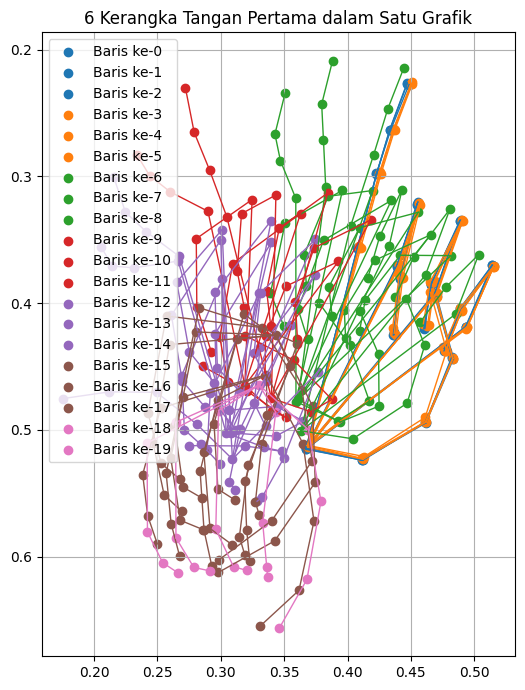

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Misal data sudah ada di df
df = pd.read_csv("csv_separated/dinamic/raw/j.csv")

# Ambil hanya 3 baris pertama
df_subset = df.iloc[:30]

# Koneksi antar titik (MediaPipe Hand)
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20)
]

# Buat figure
plt.figure(figsize=(7, 7))

# Ambil 6 warna dari colormap 'tab10'
colors = cm.get_cmap('tab10',30)

# Plot semua kerangka dalam satu grafik
for i in range(20):
    x = [df_subset.iloc[i][f'X{j}'] for j in range(21)]
    y = [df_subset.iloc[i][f'Y{j}'] for j in range(21)]

    # Plot titik
    plt.scatter(x, y, color=colors(i), label=f'Baris ke-{i}')

    # Plot garis kerangka
    for start, end in connections:
        plt.plot([x[start], x[end]], [y[start], y[end]], color=colors(i), linewidth=1)

# Format tampilan
plt.title("6 Kerangka Tangan Pertama dalam Satu Grafik")
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## VISUALISASI PERUBAHAN LANDMARK

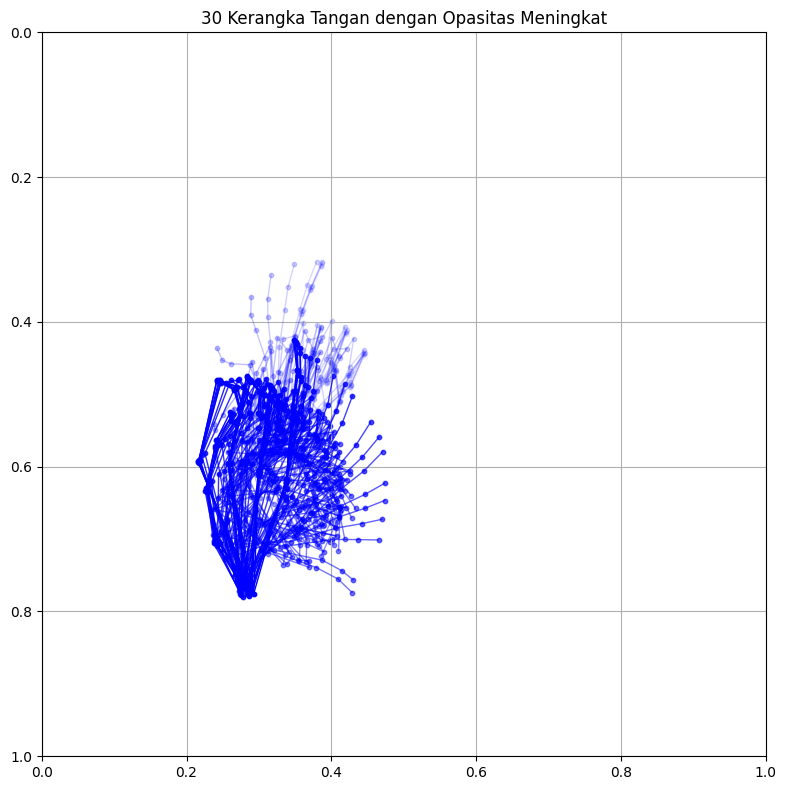

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data

df =df[(df['sequence']==21)&(df['Label']=='j')]
df_subset = df.iloc[:]  # Ambil 30 baris pertama

# Koneksi titik berdasarkan MediaPipe Hand
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20)
]

# Buat figure
plt.figure(figsize=(8, 8))

# Warna dasar (misalnya biru tua)
base_color = 'blue'

# Plot semua kerangka dalam satu grafik
for i in range(len(df_subset)):
    x = [df_subset.iloc[i][f'Xl{j}'] for j in range(21)]
    y = [df_subset.iloc[i][f'Yl{j}'] for j in range(21)]

    alpha_value = (i + 1) / len(df_subset)  # Dari 1/30 hingga 30/30 (semakin tinggi i, semakin tebal)

    # Plot titik
    plt.scatter(x, y, color=base_color, alpha=alpha_value, s=10)

    # Plot garis koneksi
    for start, end in connections:
        plt.plot([x[start], x[end]], [y[start], y[end]],
                 color=base_color, alpha=alpha_value, linewidth=1)

# Format tampilan
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("30 Kerangka Tangan dengan Opasitas Meningkat")
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


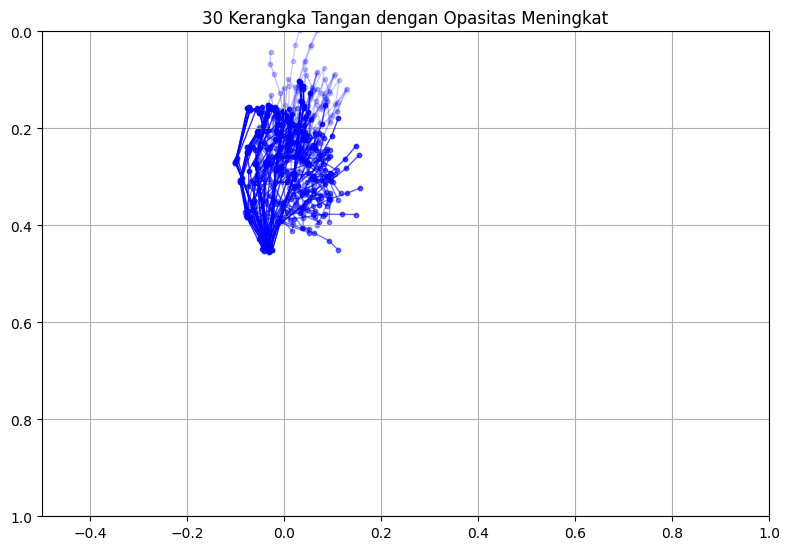

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_subset= df_trimmed[(df_trimmed['Label']=='j')&(df_trimmed['sequence']==21)]
# Koneksi titik berdasarkan MediaPipe Hand
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20)
]

# Buat figure
plt.figure(figsize=(8, 8))

# Warna dasar (misalnya biru tua)
base_color = 'blue'

# Plot semua kerangka dalam satu grafik
for i in range(len(df_subset)):
    x = [df_subset.iloc[i][f'X{j}'] for j in range(21)]
    y = [df_subset.iloc[i][f'Y{j}'] for j in range(21)]

    alpha_value = (i + 1) / len(df_subset)  # Dari 1/30 hingga 30/30 (semakin tinggi i, semakin tebal)

    # Plot titik
    plt.scatter(x, y, color=base_color, alpha=alpha_value, s=10)

    # Plot garis koneksi
    for start, end in connections:
        plt.plot([x[start], x[end]], [y[start], y[end]],
                 color=base_color, alpha=alpha_value, linewidth=1)

# Format tampilan
plt.xlim(-0.5, 1)
plt.ylim(0, 1)
plt.title("30 Kerangka Tangan dengan Opasitas Meningkat")
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


## MEMECAH FRAME FRAME VIDIO JADI FILE JPG

In [1]:
import cv2
import os

# Path ke file video
video_path = 'video3/3.mkv'

# Folder tempat menyimpan frame, yaitu 'video3/1'
output_folder = os.path.join('video3', '3')

# Buat folder jika belum ada
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Buka file video
cap = cv2.VideoCapture(video_path)
frame_number = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop jika tidak ada frame lagi

    # Simpan frame sebagai gambar JPG
    filename = os.path.join(output_folder, f"{frame_number}.jpg")
    cv2.imwrite(filename, frame)
    frame_number += 1

cap.release()
print(f"Berhasil menyimpan {frame_number - 1} frame ke folder '{output_folder}'.")


Berhasil menyimpan 751 frame ke folder 'video3/3'.


In [ ]:
# Ubah nilai 'sequence' agar dimulai dari 0 untuk setiap label secara terpisah
df_varied_start_sorted = df_varied_start.sort_values(['Label', 'sequence', 'timestep']).copy()

# Buat sequence index ulang per label
df_varied_start_sorted['sequence'] = (
    df_varied_start_sorted.groupby('Label')['sequence'].transform(lambda x: pd.factorize(x)[0])
)

# Cek hasil setelah transformasi
df_varied_start_sorted[['Label', 'sequence']].drop_duplicates().sort_values(['Label', 'sequence'])
df_varied_start_sorted


,X0,X1,X2,X3,X4,Y0,Y1,Y2,Y3,Y4,timestep,sequence,Label
175,1.135176,1.000629,0.757482,0.755514,1.010864,-1.442765,-1.265662,-1.326130,-1.544380,-1.661387,0,0,O
176,1.045736,0.920107,0.652613,0.686914,0.917987,-1.163175,-0.931112,-1.028274,-1.252262,-1.353383,1,0,O
177,0.795539,0.685244,0.478140,0.425949,0.627661,-0.982417,-0.775859,-0.850152,-1.114328,-1.188390,2,0,O
178,0.498246,0.323083,0.121438,0.163344,0.349336,-0.956322,-0.758384,-0.846003,-1.066117,-1.174531,3,0,O
179,0.199867,0.100484,-0.121525,-0.123397,0.108080,-1.162515,-0.977664,-1.029038,-1.278689,-1.329504,4,0,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,-0.582939,-0.703071,-0.938493,-0.934412,-0.694418,-0.568922,-0.358108,-0.474513,-0.708704,-0.807621,15,4,Z
171,-0.693294,-0.791410,-1.036112,-1.032622,-0.828964,-0.656439,-0.410660,-0.520903,-0.729403,-0.820527,16,4,Z
172,-0.752716,-0.906625,-1.188088,-1.147105,-0.900192,-0.675062,-0.474851,-0.553969,-0.839253,-0.847822,17,4,Z
173,-0.874969,-0.978171,-1.201224,-1.232515,-1.015338,-0.716026,-0.518574,-0.602684,-0.884680,-0.942160,18,4,Z


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-06-29 20:51:50.721764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 20:51:50.848209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751205110.910390    4893 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751205110.924723    4893 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751205111.023038    4893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1
